# A Tutorial of Variational Latent Gaussian Process Model

This tutorial shows how to use the code to reproduce part of the result in the paper.

In [1]:
%load_ext autoreload
%autoreload 2
%aimport vlgp

Firstly import modules.

In [38]:
import os
from os import path

import numpy as np
from scipy import stats
from scipy import linalg

import vlgp
from vlgp import util, simulation, math, plot

Then import and set up graphics. Borrow the palette from seaborn. 

In [96]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set(context='notebook', style='white', palette='deep', font_scale=1.5, color_codes=True)

Create the paths to the data and ouput directories. These two subdirectories are expected to exist in current directory.

In [7]:
datapath = path.abspath('data')
outputpath = path.abspath('output')

## Lorenz Dynamics

We simulate a dataset driven by 3-dimensional Lorenz dynamics defined by the following differential equations,
\begin{align} 
    x_1' &= \sigma(x_2 - x_1)     \\
    x_2' &= x_1(\rho - x_3) - x_2 \\
    x_3' &= x_1 x_2 - \beta x_3.
\end{align}

Each sample consists of 10 trials of 50 spike trains. Each trial contains 1000 time bins. The discrete latent dynamics are sampled with the time step of 0.0015. The parameters are set to $\sigma=10$, $\rho=28$ and $\beta=2.667$. We normalize the dynamics and discard the first 2000 points to get stable result.

In [167]:
nsample = 5  # number of sample
ntrial = 10  # number of trials
nbin = 1000  # number of time bins of each trial
nneuron = 50 # number of neurons (spike trains)
dim = 3      # latent dimension

To reproduce the same results as that in the paper, set the random seed and simulate 5 samples.

In [168]:
np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * nbin, dt=1.5e-3, s=10, r=28, b=2.667, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / linalg.norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, nbin, dim))  # latent dynamics in proper shape

Plot the first trial.

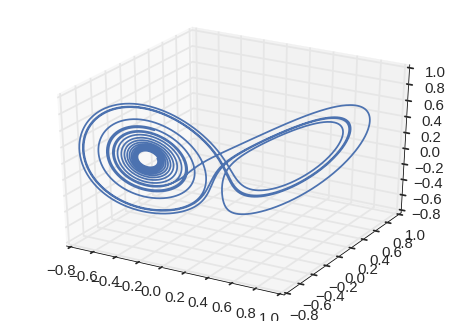

In [216]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[0, :, :, 0].ravel(), x[0, :, :, 1].ravel(), zs=x[0, :, :, 2].ravel());

Then simulate spike trains with 10-step history filter given the simulated latent dynamics. The elements of loading matrix is randomly generated from $(1, 2)$ with random signs. The history filter decays in time $(-10, -10, -3, -3, -3, -3, -2, -2, -1, -1)$. The base firing rate is 15Hz. 

The simulation function `simulation.spike` gives spike trains, design matrix of regression part and the true firing rates. We sort the loading matrix by row.

We save the simulation in HDF5 format.

In [250]:
np.random.seed(0)
bias = np.log(15 / nbin)  # log base firing rate
a = np.sort((np.random.rand(dim, nneuron) + 1) * np.sign(np.random.randn(dim, nneuron)), axis=1) # loading matrix
b = np.vstack((bias * np.ones(nneuron), -10 * np.ones(nneuron), -10 * np.ones(nneuron), -3 * np.ones(nneuron), 
                  -3 * np.ones(nneuron), -3 * np.ones(nneuron), -3 * np.ones(nneuron), -2 * np.ones(nneuron),
                  -2 * np.ones(nneuron), -1 * np.ones(nneuron), -1 * np.ones(nneuron)))  # regression weights

for i, each in enumerate(x, start=1):
    y, _, rate = simulation.spike(each, a, b)
    sample = dict(y=y, rate=rate, x=each, alpha=a, beta=b)
    util.save(sample, op.join(datapath, 'lorenz{}.h5'.format(i)))  # store the simulation

Load the first sample and plot the spike trains.

In [262]:
samples = [util.load(op.join(datapath, 'lorenz{}.h5'.format(i + 1))) for i in range(nsample)]

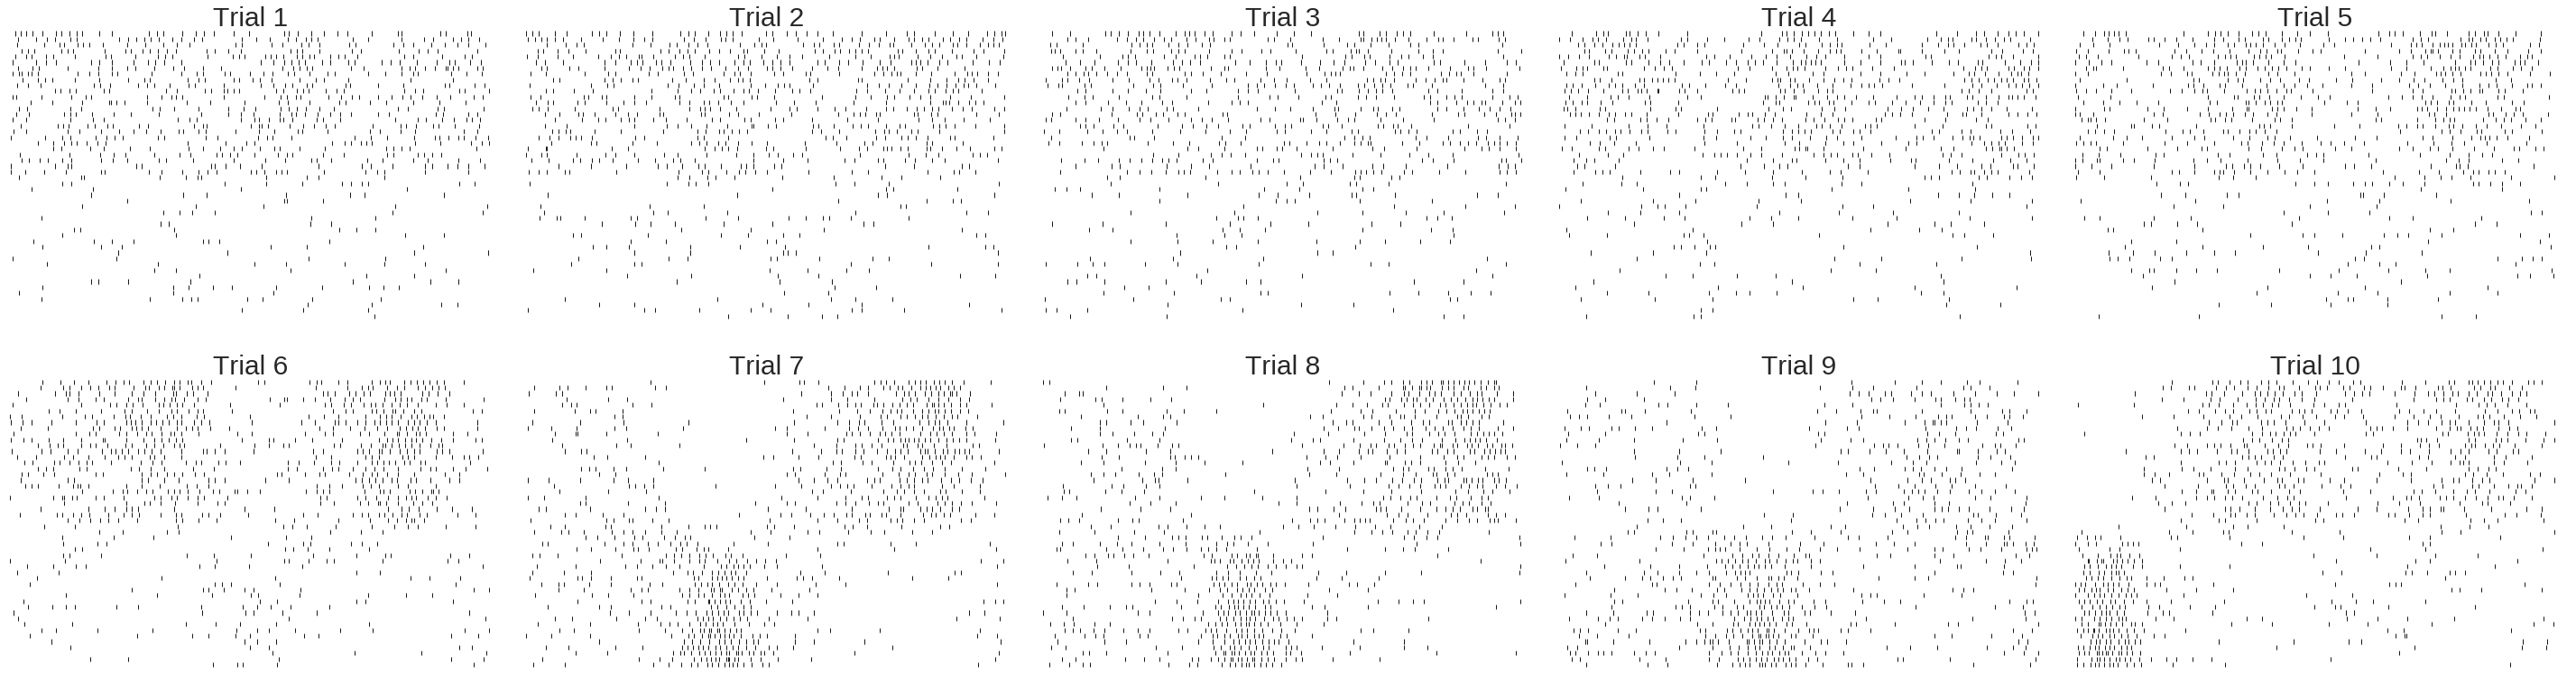

In [252]:
plot.spike(samples[0]['y'], ncol=5, fontsize=30)

### Model Fitting

Now let us do inference on the first sample. Firstly we need to set the random seed in order to get reproducible result because the algorithm does subsampling in the hyperparameters optimization steps. 

The `fit` function requires the observation array, list of channel types, initial values of hyperparameters, lag and rank of prior covariance decomposition. The observation array is supposed to be in the shape of (trial, bin, channel). The 'spike' channel indicates it is a spike train (Poisson). 

The function also needs the true values of latent and parameters to calculate the angle between subspaces and other statistics.

The rest arguments are options controlling the behavior of algorithm.
* niter: max number of iterations
* tol: relative tolerance for checking convergence
* adjhess: adjust Hessian by gradient
* decay: decay speed for the adjustment to Hessian
* verbose: display info in every iteration
* learn_post: optimize the posterior
* learn_param: optimize the parameters
* learn_sigma: optimize prior variance
* learn_omega: optimize prior timescale
* nhyper: optimize hyperparameters every nhyper iteration

We can save the fitted model in HDF5 format. Note that HDF5 does not support array of strings and thus remove it before saving.

In [263]:
for i, sample in enumerate(samples, start=1):
    np.random.seed(0)
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    fitted, _ = vlgp.fit(sample['y'], ['spike']*sample['y'].shape[-1], 
                         sigma, omega, 
                         lag=10, rank=100, 
                         x=sample['x'], alpha=sample['alpha'], beta=sample['beta'],  
                         niter=50, tol=1e-5, adjhess=True, decay=0, verbose=False, learn_post=True, learn_param=True,
                         learn_sigma=True, learn_omega=True, nhyper=5)
    fitted.pop('channel', None)
    util.save(fitted, op.join(outputpath, 'lorenz{}.h5'.format(i + 1)))

Load results.

In [264]:
fits = [util.load(op.join(outputpath, 'lorenz{}.h5'.format(i + 1))) for i in range(nsample)]

Plot the angle between subspaces of latent. The x-axis is the time consumed by each iteration. The times are recorded in the array named `Elapsed`. The array contains 3 columns that are the times used by posterior step, parameter step and the whole iteration. The first row are 0s that corresponds to the initialization. Thus we have to set the first row to 1 for log scale.

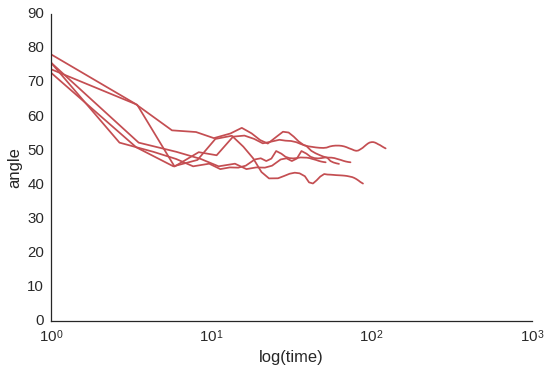

In [265]:
plt.figure()
for fitted in fits:
    fitted['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(fitted['Elapsed'][:, 2]), fitted['LatentAngle'], color='r')
plt.xlabel('log(time)')
plt.ylabel('angle')
plt.ylim(0, 90)
sns.despine(top=True, right=True)
plt.tight_layout()

### Leave-one-out Cross Validation

We use a leave-one-neuron-out prediction likelihood to compare models.
We choose one of the trials as test trial and the others as training trials.
First, the weights and posterior are inferred from the training trials.
Next, we leave one neuron out of the test trial and make inference on the posterior of the test trial given the rest neurons and the weights estimated from the training trials.
Then the firing rates of the very neuron are predicted by the model given the weights from the training trials and the posterior inferred from the rest of neurons in the test trial.
We do this procedure on each neuron of one trial and each trial of the sample.
Finally we obtain the prediction of all neurons at all time bins of the sample.

Here we fixed the hyperparameters to the values inferred early.

_The cross validation takes very long time. You may skip the following code and load the result directly._

In [266]:
for i, (sample, fitted) in enumerate(zip(samples, fits), start=1):
    sigma = fitted['sigma']
    omega = fitted['omega']
    result = vlgp.cv(sample['y'], ['spike']*sample['y'].shape[-1], 
                     sigma, omega, lag=10, rank=100,  
                     niter=50, tol=1e-5, adjhess=True, decay=0, verbose=False, learn_post=True, learn_param=True,
                     learn_sigma=False, learn_omega=False, nhyper=5)

    util.save(result, op.join(outputpath, 'lorenz{}cv.h5'.format(i)))

Calculate predictive log-likelihood (PLL)
\begin{equation}
    PLL = \frac{LL_{model} - LL_{null}}{\text{# of spikes}}
\end{equation}

In [271]:
cvs = [util.load(op.join(outputpath, 'lorenz{}cv.h5'.format(i + 1))) for i in range(nsample)]

In [273]:
for i, cv in enumerate(cvs, start=1):
    mll = stats.poisson.logpmf(cv['y'], cv['yhat']).sum()  # model ll
    nll = stats.poisson.logpmf(cv['y'], cv['y'].mean()).sum()  # null ll
    pll = (mll - nll) / np.log(2) / cv['y'].sum()
    print('Sample {} PLL = {:.2f} bit/spike'.format(i, pll))

Sample 1 PLL = 0.58 bit/spike
Sample 2 PLL = 0.74 bit/spike
Sample 3 PLL = 0.74 bit/spike
Sample 4 PLL = 0.73 bit/spike
Sample 5 PLL = 0.66 bit/spike
